# Error Analysis

Let's check out what's our model doing wrong

In [1]:
%load_ext autoreload
%autoreload 2
import os
from datetime import datetime
import fire
import torch
import pandas as pd
from torchtext import data
import torch.nn as nn
from transformers import (
    AdamW, BertForSequenceClassification, BertTokenizer,
    get_constant_schedule_with_warmup
)

from offenseval.nn import (
    Tokenizer,
    train, evaluate, train_cycle, save_model, load_model, evaluate_dataset
)
from offenseval.datasets import datasets

pd.options.display.max_rows = 200
pd.options.display.max_colwidth = 300

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model, TEXT = load_model("../models/bert_cased.all.pt", device)
model.eval();

/home/jmperez/.local/share/virtualenvs/offenseval2020-HKdlw5Be/lib/python3.6/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'transformers.modeling_bert.BertSelfAttention' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Load the dataset as a `pd.DataFrame` (it could be done in the previous cell but well...)

In [2]:
from offenseval.nn.evaluation import evaluate
from offenseval.nn import EvaluationReport
from tqdm.auto import tqdm

dataset_path = datasets["english"]["test"]
report = evaluate_dataset(model, TEXT, dataset_path)

report


Loading dataset...
Building iterators


Acc: 91.46% Macro F1 0.899 (P 0.860 - N 0.939)

Create dataframe with predictions, probas, and so on

In [3]:
import csv

df = pd.read_table(dataset_path, index_col=0, 
                   quoting=csv.QUOTE_NONE)

df["label"] = df["subtask_a"] == 'OFF'

df["prob"] = report.probas.numpy()
df["pred"] = df["prob"] > 0.5


In [4]:
def calculate_confusion_matrix(df, label_col, pred_col):
    true_positives = df[df[label_col] & df[pred_col]].copy()
    true_negatives = df[~df[label_col] & ~df[pred_col]].copy()
    
    errors = df[df[label_col] != df[pred_col]]

    false_positives = errors[errors[pred_col]].copy()
    false_positives.sort_values(pred_col, ascending=False, inplace=True)

    false_negatives = errors[errors[label_col]].copy()
    false_negatives.sort_values(pred_col, ascending=True, inplace=True)

    return true_positives, true_negatives, false_positives, false_negatives

true_pos, true_neg, false_pos, false_neg = calculate_confusion_matrix(df, "label", "pred")

conf_matrix = pd.DataFrame([
    {"real":"not", "pred_false": len(true_neg), "pred_true": len(false_pos), },
    {"real":"off", "pred_false": len(false_neg), "pred_true": len(true_pos), },
])



conf_matrix.set_index("real", inplace=True)

print("Falsos negativos: {}".format(len(false_neg)))
print("Falsos positivos: {}".format(len(false_pos)))

conf_matrix

Falsos negativos: 62
Falsos positivos: 270


,pred_false,pred_true
real,,
not,2537,270
off,62,1018


Plot it as a heatmap so it's more graphical

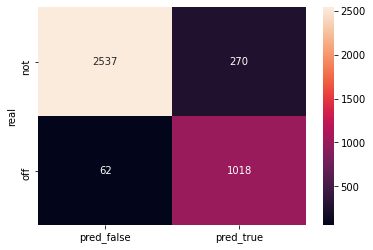

In [5]:
import seaborn as sns

sns.heatmap(conf_matrix, annot=True, fmt="")

Let's check out the false negatives. We have already ordered them by probability, so top rows are "worst" errors

## Captum

See [this issue in github for an explanation](https://github.com/pytorch/captum/issues/150)

First, let's retrieve the bert tokenizer in a very obscure way...

In [6]:
tokenizer_wrapper = TEXT.tokenize.__self__

bert_tokenizer = tokenizer_wrapper.bert_tokenizer

We need to use a wrapper

In [7]:
import torch
import torch.nn as nn

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, BertConfig

from captum.attr import IntegratedGradients
from captum.attr import InterpretableEmbeddingBase, TokenReferenceBase
from captum.attr import visualization
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer


def compute_bert_outputs(model_bert, embedding_output, attention_mask=None, head_mask=None):
    if attention_mask is None:
        attention_mask = torch.ones(embedding_output.shape[0], embedding_output.shape[1]).to(embedding_output)

    extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)

    extended_attention_mask = extended_attention_mask.to(dtype=next(model_bert.parameters()).dtype) # fp16 compatibility
    extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0

    if head_mask is not None:
        if head_mask.dim() == 1:
            head_mask = head_mask.unsqueeze(0).unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
            head_mask = head_mask.expand(model_bert.config.num_hidden_layers, -1, -1, -1, -1)
        elif head_mask.dim() == 2:
            head_mask = head_mask.unsqueeze(1).unsqueeze(-1).unsqueeze(-1)  # We can specify head_mask for each layer
        head_mask = head_mask.to(dtype=next(model_bert.parameters()).dtype) # switch to fload if need + fp16 compatibility
    else:
        head_mask = [None] * model_bert.config.num_hidden_layers

    encoder_outputs = model_bert.encoder(embedding_output,
                                         extended_attention_mask,
                                         head_mask=head_mask)
    sequence_output = encoder_outputs[0]
    pooled_output = model_bert.pooler(sequence_output)
    outputs = (sequence_output, pooled_output,) + encoder_outputs[1:]  # add hidden_states and attentions if they are here
    return outputs  # sequence_output, pooled_output, (hidden_states), (attentions)    



class BertModelWrapper(nn.Module):
    
    def __init__(self, model):
        super(BertModelWrapper, self).__init__()
        self.model = model
        
    def forward(self, embeddings):        
        outputs = compute_bert_outputs(self.model.bert, embeddings)
        pooled_output = outputs[1]
        pooled_output = self.model.dropout(pooled_output)
        logits = self.model.classifier(pooled_output)
        return torch.sigmoid(logits).unsqueeze(1)

bert_model_wrapper = BertModelWrapper(model)
ig = IntegratedGradients(bert_model_wrapper)


In [ ]:
class VisualizationRecord

In [8]:


def interpret_sentence(model_wrapper, sentence, label, original_pred=None):
    model = model_wrapper.model
    model.eval()
    model.zero_grad()
    
    input_ids = torch.tensor([bert_tokenizer.encode(sentence, add_special_tokens=True)]).to(device)
    input_embedding = model.bert.embeddings(input_ids)
    
    
    baseline_ids = [bert_tokenizer.cls_token_id] 
    baseline_ids+= [bert_tokenizer.pad_token_id] * (len(input_ids[0]) - 2) 
    baseline_ids+= [bert_tokenizer.sep_token_id]
    baseline_ids = torch.tensor(baseline_ids).view(1, -1).to(device)

    baseline_embeddings = model.bert.embeddings(baseline_ids)
    # predict
        
    pred = model_wrapper(input_embedding).item()
    pred_ind = round(pred)

    # compute attributions and approximation delta using integrated gradients
    attributions_ig, delta = ig.attribute(input_embedding, baselines=baseline_embeddings,
                                          n_steps=50, return_convergence_delta=True)

    tokens = bert_tokenizer.convert_ids_to_tokens(input_ids[0].cpu().numpy().tolist())
    return create_vis_record(attributions_ig, tokens, pred, pred_ind, label, delta.cpu().detach().numpy())
    
    
def create_vis_record(attributions, tokens, pred, pred_ind, label, delta):
    attributions = attributions.sum(dim=2).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    attributions = attributions.cpu().detach().numpy()
    # import ipdb; ipdb.set_trace()
    # storing couple samples in an array for visualization purposes
    return visualization.VisualizationDataRecord(
        attributions,
        pred,
        pred_ind,
        label,
        "label",
        attributions.sum(),       
        tokens[:len(attributions)],
        delta
    )


In [19]:
visualization.format_special_tokens??

Signature: visualization.format_special_tokens(token)
Docstring: <no docstring>
Source:   
def format_special_tokens(token):
    if token.startswith("<") and token.endswith(">"):
        return "#" + token.strip("<>")
    return token
File:      ~/projects/offenseval2020/captum/captum/attr/_utils/visualization.py
Type:      function


In [40]:


def format_word_importances(words, importances):
    if importances is None or len(importances) == 0:
        return "<td></td>"
    assert len(words) <= len(importances)
    tags = ["<td>"]
    for word, importance in zip(words, importances[: len(words)]):
        if word.startswith("##"):
            word = word.strip("##")
            space = ""
        else:
            space = ' '
        color = visualization._get_color(importance)
        unwrapped_tag = f'<mark style="background-color: {color}; opacity:1.0; \
                    line-height:1.75"><font color="black">{space}{word}</font></mark>'
        tags.append(unwrapped_tag)
    tags.append("</td>")
    return "".join(tags)

In [41]:
from IPython.core.display import display, HTML

def display_row(text):
    return f"<td> {text} </td>"

def display_class(val):
    if type(val) is str:
        return val
    else:
        return 'OFF' if int(val) == 1 else 'NOT'

def my_visualization(vis_records):
    dom = ["<table width: 100%>"]
    rows = [
        "<tr><th>True Label</th>"
        "<th>Predicted Label</th>"
        "<th>Predict Probability</th>"
        "<th>Word Importance</th>"
    ]
    for datarecord in vis_records:
        rows.append(
            "".join(
                [
                    "<tr>",
                    display_row(display_class(datarecord.true_class)),
                    display_row(display_class(datarecord.pred_class)),
                    display_row(f"{datarecord.pred_prob:.2f}"),
                    format_word_importances(
                        datarecord.raw_input, datarecord.word_attributions
                    ),
                    "<tr>",
                ]
            )
        )

    dom.append("".join(rows))
    dom.append("</table>")
    display(HTML("".join(dom)))

In [ ]:
from tqdm.auto import tqdm

false_pos_vis = []
false_neg_vis = []
true_pos_vis = []
true_neg_vis = []

"""
for _, row in tqdm(true_neg.iterrows(), total=len(true_neg)):
    true_neg_vis.append(
        interpret_sentence(bert_model_wrapper, sentence=row.tweet, label=row.subtask_a)
    )

for _, row in tqdm(true_pos.iterrows(), total=len(true_pos)):
    true_pos_vis.append(
        interpret_sentence(bert_model_wrapper, sentence=row.tweet, label=row.subtask_a)
    )
"""

for _, row in tqdm(false_pos.iterrows(), total=len(false_pos)):
    false_pos_vis.append(
        interpret_sentence(bert_model_wrapper, sentence=row.tweet, label=row.subtask_a)
    )
    
for _, row in tqdm(false_neg.iterrows(), total=len(false_neg)):
    false_neg_vis.append(
        interpret_sentence(bert_model_wrapper, sentence=row.tweet, label=row.subtask_a)
    )
    


## False Pos

We can observe a lot of reliance in words (for instance `sucks, stupid`). However, it is not clear whether it should

In [42]:

my_visualization(false_pos_vis)

In [43]:
from offenseval.nn.evaluation import predict_sentence



## False Negative


In [12]:
my_visualization(false_neg_vis)

In [13]:
sentence = df.iloc[-1].tweet
model_wrapper = bert_model_wrapper

model_wrapper.eval()
model_wrapper.zero_grad()

input_ids = torch.tensor([bert_tokenizer.encode(sentence, add_special_tokens=True)]).to(device)
input_embedding = model_wrapper.model.bert.embeddings(input_ids)

baseline_ids = [bert_tokenizer.cls_token_id] 
baseline_ids+= [bert_tokenizer.pad_token_id] * (len(input_ids[0]) - 2) 
baseline_ids+= [bert_tokenizer.sep_token_id]
baseline_ids = torch.tensor(baseline_ids).view(1, -1).to(device)

baseline_embeddings = model_wrapper.model.bert.embeddings(baseline_ids)
# predict
pred = model_wrapper(input_embedding).item()
pred_ind = round(pred)

# compute attributions and approximation delta using integrated gradients
attributions_ig, delta = ig.attribute(input_embedding, baselines=baseline_embeddings,
                                      n_steps=50, return_convergence_delta=True)

tokens = bert_tokenizer.convert_ids_to_tokens(input_ids[0].cpu().numpy().tolist())
